# VAE for MNIST clustering and generation

The goal of this notebook is to explore some recent works dealing with variational auto-encoder (VAE).

We will use MNIST dataset and a basic VAE architecture. 

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size)) 
    except:
        out, _, _ = model(x.view(-1, image_size)) 
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

def plot_conditional_generation(model, n=8, fix_number=None):
    with torch.no_grad():
        matrix = np.zeros((n,n_classes))
        matrix[:,0] = 1

        if fix_number is None:
            final = matrix[:]
            for i in range(1,n_classes):
                final = np.vstack((final,np.roll(matrix,i)))
            #z = torch.randn(8*n_classes, z_dim).to(device)
            z = torch.randn(8, z_dim)
            z = z.repeat(n_classes,1).to(device)
            y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)
        else:
            z = torch.randn(n, z_dim).to(device)
            y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=128, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

# Variational Autoencoders

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
\begin{eqnarray*}
\mathcal{L} = \mathbf{E}_{p_d(x)}\left[\log p_\theta(x)\right]=\mathbf{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}}p_{\theta}(x|z)p(z)dz\right],
  \end{eqnarray*}
  where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

 To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instead maximize a lower bound to the log-likelihood:
  \begin{eqnarray*}
\mathcal{L} \geq L(p_\theta(x|z),q(z|x)) =\mathbf{E}_{p_d(x)}\left[\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]-\mathrm{KL}\left( q(z|x)||p(z)\right)\right].
  \end{eqnarray*}
  Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$.
  
The variational posterior $q_{\phi}(z|x)$ is also called the **encoder** and the generative model $p_{\theta}(x|z)$, the **decoder** or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), I)$ the term $\log p_\theta(x|z)$ reduces to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0, I)$.

Variational Autoencoders were introduced by [Kingma and Welling (2013)](https://arxiv.org/abs/1312.6114), see also [(Doersch, 2016)](https://arxiv.org/abs/1606.05908) for a tutorial.

There are various examples of VAE in PyTorch available [here](https://github.com/pytorch/examples/tree/master/vae) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65). The code below is taken from this last source.

![A variational autoencoder.](vae.png)

In [4]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take Binary Cross-Entropy. The code below is still from the PyTorch tutorial (with minor modifications to avoid warnings!).

In [5]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/15], Step [10/469], Reconst Loss: 274.4249, KL Div: 30.9702
Epoch[1/15], Step [20/469], Reconst Loss: 229.9410, KL Div: 9.0791
Epoch[1/15], Step [30/469], Reconst Loss: 216.6197, KL Div: 9.6331
Epoch[1/15], Step [40/469], Reconst Loss: 220.2027, KL Div: 5.1560
Epoch[1/15], Step [50/469], Reconst Loss: 209.2249, KL Div: 5.2660
Epoch[1/15], Step [60/469], Reconst Loss: 199.6494, KL Div: 6.6996
Epoch[1/15], Step [70/469], Reconst Loss: 185.4102, KL Div: 9.1160
Epoch[1/15], Step [80/469], Reconst Loss: 175.4594, KL Div: 9.4649
Epoch[1/15], Step [90/469], Reconst Loss: 178.5814, KL Div: 9.8404
Epoch[1/15], Step [100/469], Reconst Loss: 181.4238, KL Div: 9.2372
Epoch[1/15], Step [110/469], Reconst Loss: 171.6484, KL Div: 11.2110
Epoch[1/15], Step [120/469], Reconst Loss: 163.3552, KL Div: 12.1876
Epoch[1/15], Step [130/469], Reconst Loss: 160.4736, KL Div: 12.5166
Epoch[1/15], Step [140/469], Reconst Loss: 152.8711, KL Div: 13.5351
Epoch[1/15], Step [150/469], Reconst Loss: 151.7530,

Epoch[3/15], Step [310/469], Reconst Loss: 90.5817, KL Div: 24.2304
Epoch[3/15], Step [320/469], Reconst Loss: 89.1934, KL Div: 24.2556
Epoch[3/15], Step [330/469], Reconst Loss: 88.0361, KL Div: 24.5653
Epoch[3/15], Step [340/469], Reconst Loss: 87.0126, KL Div: 23.5388
Epoch[3/15], Step [350/469], Reconst Loss: 90.3679, KL Div: 24.2648
Epoch[3/15], Step [360/469], Reconst Loss: 84.8779, KL Div: 23.6091
Epoch[3/15], Step [370/469], Reconst Loss: 86.6137, KL Div: 24.6787
Epoch[3/15], Step [380/469], Reconst Loss: 89.7776, KL Div: 24.1681
Epoch[3/15], Step [390/469], Reconst Loss: 87.6337, KL Div: 23.6826
Epoch[3/15], Step [400/469], Reconst Loss: 85.3283, KL Div: 24.1471
Epoch[3/15], Step [410/469], Reconst Loss: 86.4487, KL Div: 24.2602
Epoch[3/15], Step [420/469], Reconst Loss: 86.2365, KL Div: 24.2874
Epoch[3/15], Step [430/469], Reconst Loss: 88.8758, KL Div: 24.0850
Epoch[3/15], Step [440/469], Reconst Loss: 88.2897, KL Div: 24.8088
Epoch[3/15], Step [450/469], Reconst Loss: 92.52

Epoch[6/15], Step [150/469], Reconst Loss: 82.9623, KL Div: 25.0615
Epoch[6/15], Step [160/469], Reconst Loss: 83.8680, KL Div: 25.0555
Epoch[6/15], Step [170/469], Reconst Loss: 84.5412, KL Div: 24.6293
Epoch[6/15], Step [180/469], Reconst Loss: 85.2780, KL Div: 24.3538
Epoch[6/15], Step [190/469], Reconst Loss: 84.1436, KL Div: 25.6450
Epoch[6/15], Step [200/469], Reconst Loss: 86.4001, KL Div: 25.5149
Epoch[6/15], Step [210/469], Reconst Loss: 84.9889, KL Div: 24.5846
Epoch[6/15], Step [220/469], Reconst Loss: 81.0966, KL Div: 25.5895
Epoch[6/15], Step [230/469], Reconst Loss: 84.0774, KL Div: 25.8161
Epoch[6/15], Step [240/469], Reconst Loss: 80.7278, KL Div: 24.0685
Epoch[6/15], Step [250/469], Reconst Loss: 83.8353, KL Div: 25.9236
Epoch[6/15], Step [260/469], Reconst Loss: 89.3827, KL Div: 24.5787
Epoch[6/15], Step [270/469], Reconst Loss: 84.5019, KL Div: 25.3878
Epoch[6/15], Step [280/469], Reconst Loss: 84.9648, KL Div: 25.2354
Epoch[6/15], Step [290/469], Reconst Loss: 86.97

Epoch[8/15], Step [450/469], Reconst Loss: 81.0748, KL Div: 24.9151
Epoch[8/15], Step [460/469], Reconst Loss: 82.1430, KL Div: 24.8058
Epoch[9/15], Step [10/469], Reconst Loss: 81.0141, KL Div: 24.6359
Epoch[9/15], Step [20/469], Reconst Loss: 77.7708, KL Div: 25.4456
Epoch[9/15], Step [30/469], Reconst Loss: 82.5702, KL Div: 25.0767
Epoch[9/15], Step [40/469], Reconst Loss: 80.2441, KL Div: 25.9000
Epoch[9/15], Step [50/469], Reconst Loss: 80.2676, KL Div: 24.7465
Epoch[9/15], Step [60/469], Reconst Loss: 82.8942, KL Div: 25.4947
Epoch[9/15], Step [70/469], Reconst Loss: 85.1735, KL Div: 25.9611
Epoch[9/15], Step [80/469], Reconst Loss: 78.9203, KL Div: 25.0502
Epoch[9/15], Step [90/469], Reconst Loss: 85.3409, KL Div: 25.4851
Epoch[9/15], Step [100/469], Reconst Loss: 84.0289, KL Div: 25.0343
Epoch[9/15], Step [110/469], Reconst Loss: 78.5400, KL Div: 25.5012
Epoch[9/15], Step [120/469], Reconst Loss: 81.9392, KL Div: 25.4667
Epoch[9/15], Step [130/469], Reconst Loss: 80.7684, KL Di

Epoch[11/15], Step [270/469], Reconst Loss: 84.4120, KL Div: 25.8943
Epoch[11/15], Step [280/469], Reconst Loss: 79.9703, KL Div: 25.0497
Epoch[11/15], Step [290/469], Reconst Loss: 82.9286, KL Div: 25.5045
Epoch[11/15], Step [300/469], Reconst Loss: 79.5127, KL Div: 24.6292
Epoch[11/15], Step [310/469], Reconst Loss: 79.1733, KL Div: 25.6407
Epoch[11/15], Step [320/469], Reconst Loss: 79.9744, KL Div: 25.3903
Epoch[11/15], Step [330/469], Reconst Loss: 78.9302, KL Div: 25.2605
Epoch[11/15], Step [340/469], Reconst Loss: 79.4883, KL Div: 26.6285
Epoch[11/15], Step [350/469], Reconst Loss: 81.4826, KL Div: 24.4994
Epoch[11/15], Step [360/469], Reconst Loss: 79.5267, KL Div: 25.8314
Epoch[11/15], Step [370/469], Reconst Loss: 80.7012, KL Div: 25.6635
Epoch[11/15], Step [380/469], Reconst Loss: 80.4856, KL Div: 24.2417
Epoch[11/15], Step [390/469], Reconst Loss: 82.2636, KL Div: 25.4717
Epoch[11/15], Step [400/469], Reconst Loss: 81.8161, KL Div: 25.1500
Epoch[11/15], Step [410/469], Reco

Epoch[14/15], Step [90/469], Reconst Loss: 77.9022, KL Div: 25.1710
Epoch[14/15], Step [100/469], Reconst Loss: 79.6319, KL Div: 25.7020
Epoch[14/15], Step [110/469], Reconst Loss: 79.2905, KL Div: 24.9275
Epoch[14/15], Step [120/469], Reconst Loss: 78.4111, KL Div: 25.2015
Epoch[14/15], Step [130/469], Reconst Loss: 75.8103, KL Div: 25.1406
Epoch[14/15], Step [140/469], Reconst Loss: 79.2165, KL Div: 25.3476
Epoch[14/15], Step [150/469], Reconst Loss: 78.0722, KL Div: 25.2466
Epoch[14/15], Step [160/469], Reconst Loss: 81.7863, KL Div: 25.3990
Epoch[14/15], Step [170/469], Reconst Loss: 77.8482, KL Div: 25.2353
Epoch[14/15], Step [180/469], Reconst Loss: 81.0164, KL Div: 25.7553
Epoch[14/15], Step [190/469], Reconst Loss: 81.1258, KL Div: 25.7920
Epoch[14/15], Step [200/469], Reconst Loss: 75.8863, KL Div: 24.7707
Epoch[14/15], Step [210/469], Reconst Loss: 75.3739, KL Div: 25.9363
Epoch[14/15], Step [220/469], Reconst Loss: 82.7865, KL Div: 26.4198
Epoch[14/15], Step [230/469], Recon

Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

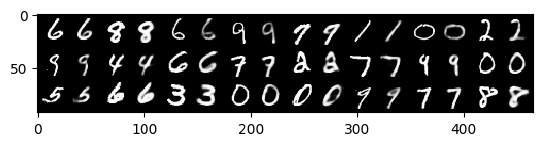

In [6]:
plot_reconstruction(model)

Let's see now how our network generates new samples.

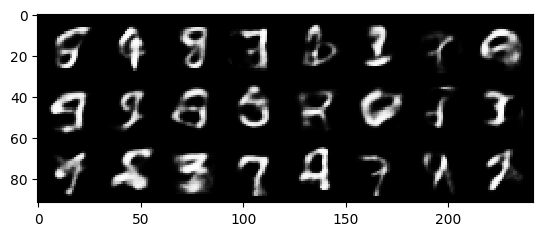

In [7]:
plot_generation(model)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. In the rest of this notebook, we explore ways to generates zeroes, ones, twos and so on. 


As a by-product, we show how our VAE will allow us to do clustering tahnsk to the Gumbel VAE described below. But before that, we start by cheatin a little bit...

# Cheating with the 'conditional' VAE

We will first use the labels here (like what we did in the course with [Conditional GAN](https://dataflowr.github.io/website/modules/10-generative-adversarial-networks/)). The idea is to modify slightly the architecture above by feeding a onehot version of the label to the decoder in addition to the code computed by the decoder. 

First code a function transforming a label in its onehot encoding. This function will be used in the training loop (not in the architecture of the neural network!).

In [8]:
n_classes = 10
def l_2_onehot(labels,nb_digits=n_classes):
    # take labels (from the dataloader) and return labels onehot-encoded
    l_onehot = torch.FloatTensor(labels.shape[0], nb_digits)
    l_onehot.zero_()
    l_onehot.scatter_(1, labels.unsqueeze(1), 1)
    return l_onehot

You can test it on a batch.

In [9]:
(x,labels) = next(iter(data_loader))

In [10]:
labels

tensor([2, 0, 9, 3, 1, 0, 8, 5, 6, 0, 4, 2, 4, 1, 6, 8, 5, 7, 3, 6, 5, 2, 1, 8,
        6, 7, 4, 4, 7, 8, 1, 4, 0, 8, 9, 8, 2, 7, 1, 7, 3, 8, 2, 1, 2, 7, 3, 7,
        9, 8, 9, 9, 5, 6, 9, 3, 2, 9, 0, 7, 8, 1, 9, 7, 4, 9, 2, 8, 0, 7, 7, 3,
        1, 0, 2, 9, 6, 5, 1, 0, 5, 7, 9, 4, 3, 5, 5, 9, 4, 8, 8, 1, 5, 9, 2, 7,
        3, 6, 9, 7, 2, 5, 0, 3, 3, 1, 1, 3, 2, 0, 8, 6, 3, 1, 5, 8, 0, 4, 5, 7,
        3, 7, 9, 9, 0, 8, 1, 7])

In [11]:
l_2_onehot(labels)

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

Now modifiy the architecture of the VAE where the decoder takes as input the random code concatenated with the onehot encoding of the label.

In [12]:
n_classes = 10

class VAE_Cond(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Cond, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim+n_classes, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, l_onehot):
        x = torch.cat([z, l_onehot], 1)
        h = F.relu(self.fc4(x))
        return torch.sigmoid(self.fc5(h))     
    
    def forward(self, x, l_onehot):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z,l_onehot)
        return x_reconst, mu, log_var

Test your new model on a batch:

In [13]:
model_C = VAE_Cond().to(device)
x = x.to(device).view(-1, image_size)
l_onehot = l_2_onehot(labels)
l_onehot = l_onehot.to(device)
model_C(x, l_onehot)

(tensor([[0.5013, 0.5295, 0.4564,  ..., 0.4432, 0.4528, 0.5620],
         [0.4989, 0.5340, 0.5662,  ..., 0.4467, 0.4913, 0.5849],
         [0.4751, 0.5649, 0.5416,  ..., 0.4234, 0.4822, 0.5361],
         ...,
         [0.4473, 0.4697, 0.5232,  ..., 0.5286, 0.3867, 0.5601],
         [0.4885, 0.5402, 0.5513,  ..., 0.4202, 0.4395, 0.5738],
         [0.4421, 0.4926, 0.4449,  ..., 0.4485, 0.4463, 0.5546]],
        device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([[-0.0433, -0.0832,  0.0091,  ...,  0.1585, -0.0184,  0.0606],
         [ 0.1620, -0.0522, -0.0598,  ...,  0.1157, -0.1724, -0.1407],
         [-0.0765, -0.0521,  0.0484,  ...,  0.0335, -0.0362, -0.0366],
         ...,
         [ 0.0767, -0.1065,  0.0955,  ...,  0.1742, -0.0872,  0.1011],
         [-0.0377, -0.0847, -0.0209,  ...,  0.0493, -0.0168,  0.1104],
         [-0.0784, -0.1386,  0.1181,  ...,  0.1484, -0.0814, -0.0636]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[ 7.5633e-03, -1.4208e-01,  8.1562e-03,

Now you can modify the training loop of your network. The parameter $\beta$ will allow you to scale the KL term in your loss as explained in the [$\beta$-VAE paper](https://openreview.net/forum?id=Sy2fzU9gl) see formula (4) in the paper.

In [14]:
def train_C(model, data_loader=data_loader,num_epochs=num_epochs, beta=10., verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            l_onehot = l_2_onehot(labels)
            l_onehot = l_onehot.to(device)
            labels = labels.to(device)
            x_reconst, mu, log_var = model(x,l_onehot)
            
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div =  - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            # Backprop and optimize
            loss = reconst_loss + beta*kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x),
                                   kl_div.item()/len(x)))

In [15]:
model_C = VAE_Cond().to(device)
optimizer = torch.optim.Adam(model_C.parameters(), lr=learning_rate)

In [16]:
train_C(model_C,num_epochs=15,verbose=True)

Epoch[1/15], Step [10/469], Reconst Loss: 348.3138, KL Div: 1.9303
Epoch[1/15], Step [20/469], Reconst Loss: 259.1938, KL Div: 1.3214
Epoch[1/15], Step [30/469], Reconst Loss: 220.3017, KL Div: 0.8366
Epoch[1/15], Step [40/469], Reconst Loss: 220.6763, KL Div: 0.4514
Epoch[1/15], Step [50/469], Reconst Loss: 222.4193, KL Div: 0.3216
Epoch[1/15], Step [60/469], Reconst Loss: 198.1614, KL Div: 0.3989
Epoch[1/15], Step [70/469], Reconst Loss: 201.1050, KL Div: 0.2724
Epoch[1/15], Step [80/469], Reconst Loss: 203.7372, KL Div: 0.2940
Epoch[1/15], Step [90/469], Reconst Loss: 201.1166, KL Div: 0.2300
Epoch[1/15], Step [100/469], Reconst Loss: 202.6196, KL Div: 0.2142
Epoch[1/15], Step [110/469], Reconst Loss: 194.7351, KL Div: 0.3439
Epoch[1/15], Step [120/469], Reconst Loss: 195.5732, KL Div: 0.3358
Epoch[1/15], Step [130/469], Reconst Loss: 189.0608, KL Div: 0.3422
Epoch[1/15], Step [140/469], Reconst Loss: 183.9213, KL Div: 0.3644
Epoch[1/15], Step [150/469], Reconst Loss: 186.0403, KL D

Epoch[3/15], Step [310/469], Reconst Loss: 155.1509, KL Div: 1.0683
Epoch[3/15], Step [320/469], Reconst Loss: 156.0595, KL Div: 1.0628
Epoch[3/15], Step [330/469], Reconst Loss: 155.7386, KL Div: 1.0595
Epoch[3/15], Step [340/469], Reconst Loss: 157.8554, KL Div: 1.1143
Epoch[3/15], Step [350/469], Reconst Loss: 154.3273, KL Div: 1.0680
Epoch[3/15], Step [360/469], Reconst Loss: 154.1517, KL Div: 0.9429
Epoch[3/15], Step [370/469], Reconst Loss: 159.2720, KL Div: 1.1264
Epoch[3/15], Step [380/469], Reconst Loss: 158.1656, KL Div: 1.0498
Epoch[3/15], Step [390/469], Reconst Loss: 152.0105, KL Div: 1.2000
Epoch[3/15], Step [400/469], Reconst Loss: 151.6973, KL Div: 0.9719
Epoch[3/15], Step [410/469], Reconst Loss: 151.6926, KL Div: 1.0895
Epoch[3/15], Step [420/469], Reconst Loss: 151.1534, KL Div: 1.1819
Epoch[3/15], Step [430/469], Reconst Loss: 155.6685, KL Div: 1.0651
Epoch[3/15], Step [440/469], Reconst Loss: 153.2302, KL Div: 1.2129
Epoch[3/15], Step [450/469], Reconst Loss: 152.2

Epoch[6/15], Step [150/469], Reconst Loss: 148.6172, KL Div: 1.3533
Epoch[6/15], Step [160/469], Reconst Loss: 151.2452, KL Div: 1.4401
Epoch[6/15], Step [170/469], Reconst Loss: 139.2895, KL Div: 1.3932
Epoch[6/15], Step [180/469], Reconst Loss: 147.2267, KL Div: 1.5189
Epoch[6/15], Step [190/469], Reconst Loss: 145.7315, KL Div: 1.2635
Epoch[6/15], Step [200/469], Reconst Loss: 149.9826, KL Div: 1.4389
Epoch[6/15], Step [210/469], Reconst Loss: 147.1068, KL Div: 1.3429
Epoch[6/15], Step [220/469], Reconst Loss: 149.0590, KL Div: 1.4174
Epoch[6/15], Step [230/469], Reconst Loss: 153.9519, KL Div: 1.3922
Epoch[6/15], Step [240/469], Reconst Loss: 147.6508, KL Div: 1.2980
Epoch[6/15], Step [250/469], Reconst Loss: 148.1270, KL Div: 1.5520
Epoch[6/15], Step [260/469], Reconst Loss: 140.8872, KL Div: 1.3378
Epoch[6/15], Step [270/469], Reconst Loss: 149.3622, KL Div: 1.4511
Epoch[6/15], Step [280/469], Reconst Loss: 153.9208, KL Div: 1.4300
Epoch[6/15], Step [290/469], Reconst Loss: 150.0

Epoch[8/15], Step [450/469], Reconst Loss: 149.6499, KL Div: 1.5032
Epoch[8/15], Step [460/469], Reconst Loss: 144.6571, KL Div: 1.5003
Epoch[9/15], Step [10/469], Reconst Loss: 143.4893, KL Div: 1.4399
Epoch[9/15], Step [20/469], Reconst Loss: 147.2712, KL Div: 1.5178
Epoch[9/15], Step [30/469], Reconst Loss: 141.3000, KL Div: 1.5829
Epoch[9/15], Step [40/469], Reconst Loss: 152.5769, KL Div: 1.4650
Epoch[9/15], Step [50/469], Reconst Loss: 149.8120, KL Div: 1.5962
Epoch[9/15], Step [60/469], Reconst Loss: 146.4192, KL Div: 1.6787
Epoch[9/15], Step [70/469], Reconst Loss: 143.1331, KL Div: 1.5726
Epoch[9/15], Step [80/469], Reconst Loss: 154.0710, KL Div: 1.4054
Epoch[9/15], Step [90/469], Reconst Loss: 142.9548, KL Div: 1.7188
Epoch[9/15], Step [100/469], Reconst Loss: 153.1425, KL Div: 1.6609
Epoch[9/15], Step [110/469], Reconst Loss: 144.5727, KL Div: 1.6193
Epoch[9/15], Step [120/469], Reconst Loss: 148.8130, KL Div: 1.5238
Epoch[9/15], Step [130/469], Reconst Loss: 144.5618, KL D

Epoch[11/15], Step [270/469], Reconst Loss: 145.6530, KL Div: 1.5891
Epoch[11/15], Step [280/469], Reconst Loss: 138.4326, KL Div: 1.7324
Epoch[11/15], Step [290/469], Reconst Loss: 144.8582, KL Div: 1.7314
Epoch[11/15], Step [300/469], Reconst Loss: 138.3309, KL Div: 1.5103
Epoch[11/15], Step [310/469], Reconst Loss: 139.9462, KL Div: 1.6385
Epoch[11/15], Step [320/469], Reconst Loss: 143.6163, KL Div: 1.6673
Epoch[11/15], Step [330/469], Reconst Loss: 145.8208, KL Div: 1.7128
Epoch[11/15], Step [340/469], Reconst Loss: 142.0212, KL Div: 1.6595
Epoch[11/15], Step [350/469], Reconst Loss: 146.4209, KL Div: 1.8086
Epoch[11/15], Step [360/469], Reconst Loss: 141.2029, KL Div: 1.6107
Epoch[11/15], Step [370/469], Reconst Loss: 148.7469, KL Div: 1.6714
Epoch[11/15], Step [380/469], Reconst Loss: 143.7785, KL Div: 1.5785
Epoch[11/15], Step [390/469], Reconst Loss: 139.1592, KL Div: 1.5885
Epoch[11/15], Step [400/469], Reconst Loss: 144.0421, KL Div: 1.7654
Epoch[11/15], Step [410/469], Reco

Epoch[14/15], Step [90/469], Reconst Loss: 137.9312, KL Div: 1.6625
Epoch[14/15], Step [100/469], Reconst Loss: 142.8049, KL Div: 1.8108
Epoch[14/15], Step [110/469], Reconst Loss: 145.4223, KL Div: 1.7322
Epoch[14/15], Step [120/469], Reconst Loss: 146.0563, KL Div: 1.7467
Epoch[14/15], Step [130/469], Reconst Loss: 138.2344, KL Div: 1.7980
Epoch[14/15], Step [140/469], Reconst Loss: 140.7261, KL Div: 1.7777
Epoch[14/15], Step [150/469], Reconst Loss: 142.4458, KL Div: 1.9039
Epoch[14/15], Step [160/469], Reconst Loss: 140.8967, KL Div: 1.6088
Epoch[14/15], Step [170/469], Reconst Loss: 140.8730, KL Div: 1.9564
Epoch[14/15], Step [180/469], Reconst Loss: 142.5399, KL Div: 1.7141
Epoch[14/15], Step [190/469], Reconst Loss: 126.4016, KL Div: 1.5280
Epoch[14/15], Step [200/469], Reconst Loss: 143.9468, KL Div: 1.8023
Epoch[14/15], Step [210/469], Reconst Loss: 140.4802, KL Div: 1.7634
Epoch[14/15], Step [220/469], Reconst Loss: 141.8518, KL Div: 1.7324
Epoch[14/15], Step [230/469], Recon

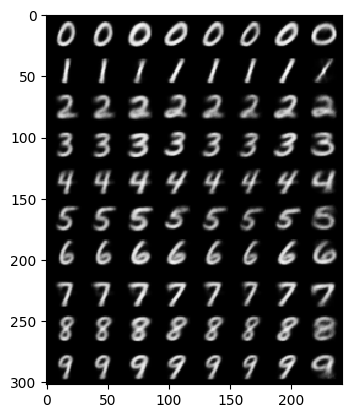

In [17]:
plot_conditional_generation(model_C, n=8)

Here you should get nice results. Now we will avoid the use of the labels...

# No cheating with Gumbel VAE

Implement a VAE where you add a categorical variable $c\in \{0,\dots 9\}$ so that your latent variable model is $p(c,z,x) = p(c)p(z)p_{\theta}(x|c,z)$ and your variational posterior is $q_{\phi}(c|x)q_{\phi}(z|x)$ as described in this NeurIPS paper: [(Dupont, 2018)](https://arxiv.org/abs/1804.00104). Make minimal modifications to previous architecture.

The idea is to incorporate a categorical variable in your latent space. You hope that this categorical variable will encode the class of the digit, so that your network can use it for a better reconstruction. Moreover, if things work as planned, you will then be able to generate digits conditionally to the class, i.e. you can choose the class thanks to the latent categorical variable $c$ and then generate digits from this class.

As noticed above, in order to sample random variables while still being able to use backpropagation, we need to use the reparameterization trick which is easy for Gaussian random variables. For categorical random variables, the reparameterization trick is explained in [(Jang et al., 2016)](https://arxiv.org/abs/1611.01144). This is implemented in PyTorch thanks to [F.gumbel_softmax](https://pytorch.org/docs/stable/nn.html?highlight=gumbel_softmax#torch.nn.functional.gumbel_softmax).

In [18]:
n_classes = 10

class VAE_Gumbel(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Gumbel, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(h_dim, n_classes)
        self.fc5 = nn.Linear(z_dim+n_classes, h_dim)
        self.fc6 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h), F.log_softmax(self.fc4(h),dim=1)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_onehot):
        x = torch.cat([z, y_onehot], 1)
        h = F.relu(self.fc5(x))
        return torch.sigmoid(self.fc6(h))
    
    def forward(self, x):
        mu, log_var, log_p = self.encode(x)
        z = self.reparameterize(mu, log_var)
        y_onehot = F.gumbel_softmax(log_p,tau=0.5,hard=True)
        x_reconst = self.decode(z,y_onehot)
        return x_reconst, mu, log_var, log_p

In [19]:
model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

You need to modify the loss to take into account the categorical random variable with an uniform prior on $\{0,\dots 9\}$, see Appendix A.2 in [(Dupont, 2018)](https://arxiv.org/abs/1804.00104)

In [20]:
def train_G(model, data_loader=data_loader,num_epochs=num_epochs, beta = 1., verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, log_p = model(x)
            _,labels_est = torch.max(log_p,1)
            all_labels += list(labels.cpu().data.numpy())
            all_labels_est += list(labels_est.cpu().data.numpy())
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div =  - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            H_cat =  -torch.sum(torch.exp(log_p)*log_p)

            # Backprop and optimize
            loss = reconst_loss + beta*(kl_div-H_cat)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x),
                                   kl_div.item()/len(x), H_cat.item()/len(x)))

In [21]:
train_G(model_G,num_epochs=10,verbose=True)

Epoch[1/10], Step [10/469], Reconst Loss: 298.0704, KL Div: 23.7714, Entropy: 1.9440
Epoch[1/10], Step [20/469], Reconst Loss: 234.9258, KL Div: 9.1024, Entropy: 2.2044
Epoch[1/10], Step [30/469], Reconst Loss: 220.9930, KL Div: 12.2237, Entropy: 2.1943
Epoch[1/10], Step [40/469], Reconst Loss: 212.0129, KL Div: 4.7374, Entropy: 2.2804
Epoch[1/10], Step [50/469], Reconst Loss: 201.3938, KL Div: 6.1574, Entropy: 2.2814
Epoch[1/10], Step [60/469], Reconst Loss: 194.3774, KL Div: 7.1824, Entropy: 2.2794
Epoch[1/10], Step [70/469], Reconst Loss: 206.2737, KL Div: 6.2790, Entropy: 2.2804
Epoch[1/10], Step [80/469], Reconst Loss: 186.9584, KL Div: 8.7917, Entropy: 2.2744
Epoch[1/10], Step [90/469], Reconst Loss: 188.4521, KL Div: 9.4335, Entropy: 2.2787
Epoch[1/10], Step [100/469], Reconst Loss: 176.4370, KL Div: 10.4698, Entropy: 2.2789
Epoch[1/10], Step [110/469], Reconst Loss: 179.0192, KL Div: 10.1710, Entropy: 2.2784
Epoch[1/10], Step [120/469], Reconst Loss: 165.7665, KL Div: 11.7126, 

Epoch[3/10], Step [50/469], Reconst Loss: 91.8824, KL Div: 22.6599, Entropy: 2.2941
Epoch[3/10], Step [60/469], Reconst Loss: 95.8198, KL Div: 23.5392, Entropy: 2.2937
Epoch[3/10], Step [70/469], Reconst Loss: 94.2666, KL Div: 24.1664, Entropy: 2.2906
Epoch[3/10], Step [80/469], Reconst Loss: 92.3231, KL Div: 23.6740, Entropy: 2.2910
Epoch[3/10], Step [90/469], Reconst Loss: 95.9179, KL Div: 23.5361, Entropy: 2.2930
Epoch[3/10], Step [100/469], Reconst Loss: 94.7956, KL Div: 24.2760, Entropy: 2.2925
Epoch[3/10], Step [110/469], Reconst Loss: 94.6584, KL Div: 24.1189, Entropy: 2.2913
Epoch[3/10], Step [120/469], Reconst Loss: 91.5363, KL Div: 22.8726, Entropy: 2.2942
Epoch[3/10], Step [130/469], Reconst Loss: 96.3462, KL Div: 24.9154, Entropy: 2.2942
Epoch[3/10], Step [140/469], Reconst Loss: 93.8244, KL Div: 23.5938, Entropy: 2.2936
Epoch[3/10], Step [150/469], Reconst Loss: 91.1092, KL Div: 24.6827, Entropy: 2.2942
Epoch[3/10], Step [160/469], Reconst Loss: 91.2352, KL Div: 24.3726, E

Epoch[5/10], Step [110/469], Reconst Loss: 87.3471, KL Div: 24.6969, Entropy: 2.2963
Epoch[5/10], Step [120/469], Reconst Loss: 82.4907, KL Div: 25.1968, Entropy: 2.2963
Epoch[5/10], Step [130/469], Reconst Loss: 86.1535, KL Div: 24.8392, Entropy: 2.2955
Epoch[5/10], Step [140/469], Reconst Loss: 88.0293, KL Div: 24.8179, Entropy: 2.2966
Epoch[5/10], Step [150/469], Reconst Loss: 89.1142, KL Div: 25.6882, Entropy: 2.2963
Epoch[5/10], Step [160/469], Reconst Loss: 86.6520, KL Div: 25.1382, Entropy: 2.2955
Epoch[5/10], Step [170/469], Reconst Loss: 85.7772, KL Div: 24.7284, Entropy: 2.2969
Epoch[5/10], Step [180/469], Reconst Loss: 84.5806, KL Div: 23.9590, Entropy: 2.2964
Epoch[5/10], Step [190/469], Reconst Loss: 91.7940, KL Div: 25.4847, Entropy: 2.2963
Epoch[5/10], Step [200/469], Reconst Loss: 86.1052, KL Div: 24.7648, Entropy: 2.2965
Epoch[5/10], Step [210/469], Reconst Loss: 88.9397, KL Div: 24.3610, Entropy: 2.2966
Epoch[5/10], Step [220/469], Reconst Loss: 83.1924, KL Div: 24.70

Epoch[7/10], Step [170/469], Reconst Loss: 82.7896, KL Div: 24.8975, Entropy: 2.2987
Epoch[7/10], Step [180/469], Reconst Loss: 82.7746, KL Div: 25.7662, Entropy: 2.2988
Epoch[7/10], Step [190/469], Reconst Loss: 79.5950, KL Div: 24.3967, Entropy: 2.2988
Epoch[7/10], Step [200/469], Reconst Loss: 83.2642, KL Div: 25.0337, Entropy: 2.2980
Epoch[7/10], Step [210/469], Reconst Loss: 84.4279, KL Div: 25.7871, Entropy: 2.2984
Epoch[7/10], Step [220/469], Reconst Loss: 85.1184, KL Div: 25.2723, Entropy: 2.2985
Epoch[7/10], Step [230/469], Reconst Loss: 87.7401, KL Div: 25.3535, Entropy: 2.2981
Epoch[7/10], Step [240/469], Reconst Loss: 80.2863, KL Div: 23.6896, Entropy: 2.2986
Epoch[7/10], Step [250/469], Reconst Loss: 85.0888, KL Div: 26.1101, Entropy: 2.2978
Epoch[7/10], Step [260/469], Reconst Loss: 82.2043, KL Div: 24.3746, Entropy: 2.2984
Epoch[7/10], Step [270/469], Reconst Loss: 79.9819, KL Div: 25.9161, Entropy: 2.2979
Epoch[7/10], Step [280/469], Reconst Loss: 83.9070, KL Div: 25.49

Epoch[9/10], Step [230/469], Reconst Loss: 81.8200, KL Div: 25.3646, Entropy: 2.2990
Epoch[9/10], Step [240/469], Reconst Loss: 82.4868, KL Div: 25.1250, Entropy: 2.2986
Epoch[9/10], Step [250/469], Reconst Loss: 79.9724, KL Div: 25.0442, Entropy: 2.2993
Epoch[9/10], Step [260/469], Reconst Loss: 81.5694, KL Div: 25.4702, Entropy: 2.2988
Epoch[9/10], Step [270/469], Reconst Loss: 81.8968, KL Div: 24.2268, Entropy: 2.2989
Epoch[9/10], Step [280/469], Reconst Loss: 79.0696, KL Div: 25.1668, Entropy: 2.2990
Epoch[9/10], Step [290/469], Reconst Loss: 80.3908, KL Div: 25.3231, Entropy: 2.2989
Epoch[9/10], Step [300/469], Reconst Loss: 81.6635, KL Div: 25.2614, Entropy: 2.2989
Epoch[9/10], Step [310/469], Reconst Loss: 83.8744, KL Div: 24.7196, Entropy: 2.2994
Epoch[9/10], Step [320/469], Reconst Loss: 80.5875, KL Div: 24.9981, Entropy: 2.2988
Epoch[9/10], Step [330/469], Reconst Loss: 85.2728, KL Div: 25.2346, Entropy: 2.2995
Epoch[9/10], Step [340/469], Reconst Loss: 81.5085, KL Div: 24.95

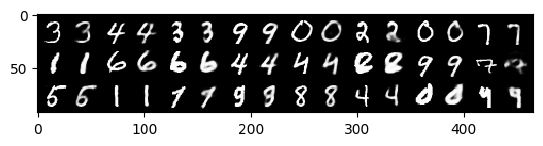

In [22]:
plot_reconstruction(model_G)

This was for reconstruction, but we care more about generation. For each category, we are generating 8 samples thanks to the `plot_conditional_generation()` function.

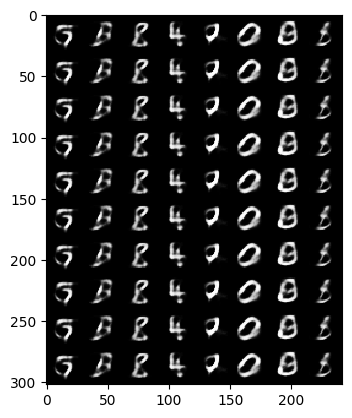

In [23]:
plot_conditional_generation(model_G, n=8)

It does not look like our original idea is working...

What is happening is that our network is not using the categorical variable. We can track the [normalized mutual information](https://en.wikipedia.org/wiki/Mutual_information#Normalized_variants) (see [this method in scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html)) between the true labels and the labels predicted by our network (just by taking the category with maximal probability). 

Change your training loop to return the normalized mutual information (NMI) for each epoch. Plot the curve to check that the NMI is actually decreasing.

This problem is explained in [(Burgess et al., 2018)](https://arxiv.org/abs/1804.03599) and a solution is proposed in Section 5.

In order to force our network to use the categorical variable, we will change the loss according to [(Dupont, 2018)](https://arxiv.org/abs/1804.00104), Section 3 Equation (7).

Implement this change in the training loop and plot the new NMI curve. For $\beta = 20, C_z=100, C_c=100$, you should see that NMI increases.

In [24]:
model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

In [25]:
def train_G_modified_loss(model, data_loader=data_loader,num_epochs=num_epochs, beta=1. , C_z_fin=0, C_c_fin=0, verbose=True):
    C_z = 0
    C_c = 0
    nmi_scores = []
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, log_p = model(x)
            _,labels_est = torch.max(log_p,1)
            all_labels += list(labels.cpu().data.numpy())
            all_labels_est += list(labels_est.cpu().data.numpy())

            # Compute reconstruction loss and kl divergence
            # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div =  -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            H_cat =  -torch.sum(torch.exp(log_p)*log_p)

            # Backprop and optimize
            loss = reconst_loss + beta*torch.abs(kl_div-C_z) + beta*torch.abs(H_cat-C_c)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item(), H_cat.item()))
        #print(all_labels_est)
        nmi_scores.append(normalized_mutual_info_score(all_labels,all_labels_est))
        C_z += C_z_fin/num_epochs
        C_c += C_c_fin/num_epochs
        
    return nmi_scores, all_labels_est 

In [26]:
# Hyper-parameters
num_epochs = 20
learning_rate = 1e-3
beta = 20
C_z_fin=100
C_c_fin=100

model_G = VAE_Gumbel(z_dim = z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

nmi, labels_est = train_G_modified_loss(model_G, data_loader, num_epochs=num_epochs, beta=beta, C_z_fin=C_z_fin, C_c_fin=C_c_fin)

Epoch[1/20], Step [10/469], Reconst Loss: 47062.4023, KL Div: 65.1455, Entropy: 287.5695
Epoch[1/20], Step [20/469], Reconst Loss: 34404.3125, KL Div: 63.7360, Entropy: 245.6900
Epoch[1/20], Step [30/469], Reconst Loss: 30626.4395, KL Div: 23.7139, Entropy: 151.7959
Epoch[1/20], Step [40/469], Reconst Loss: 28702.3789, KL Div: 18.4156, Entropy: 6.1042
Epoch[1/20], Step [50/469], Reconst Loss: 27545.7969, KL Div: 11.5643, Entropy: 0.5047
Epoch[1/20], Step [60/469], Reconst Loss: 27143.7461, KL Div: 11.2269, Entropy: 0.1183
Epoch[1/20], Step [70/469], Reconst Loss: 25626.4844, KL Div: 8.4167, Entropy: 0.1412
Epoch[1/20], Step [80/469], Reconst Loss: 27945.7168, KL Div: 9.7553, Entropy: 0.1313
Epoch[1/20], Step [90/469], Reconst Loss: 27732.2539, KL Div: 10.9553, Entropy: 0.0451
Epoch[1/20], Step [100/469], Reconst Loss: 26421.6172, KL Div: 8.1390, Entropy: 0.0410
Epoch[1/20], Step [110/469], Reconst Loss: 26486.0898, KL Div: 10.6545, Entropy: 0.1794
Epoch[1/20], Step [120/469], Reconst L

Epoch[3/20], Step [30/469], Reconst Loss: 25558.1465, KL Div: 42.6605, Entropy: 8.5495
Epoch[3/20], Step [40/469], Reconst Loss: 24922.3906, KL Div: 37.3882, Entropy: 8.3776
Epoch[3/20], Step [50/469], Reconst Loss: 25046.3086, KL Div: 40.0838, Entropy: 7.4986
Epoch[3/20], Step [60/469], Reconst Loss: 26046.6797, KL Div: 38.2925, Entropy: 9.0085
Epoch[3/20], Step [70/469], Reconst Loss: 26070.3379, KL Div: 43.2220, Entropy: 10.0062
Epoch[3/20], Step [80/469], Reconst Loss: 25380.8086, KL Div: 43.9602, Entropy: 10.6186
Epoch[3/20], Step [90/469], Reconst Loss: 25066.7637, KL Div: 43.9176, Entropy: 5.9727
Epoch[3/20], Step [100/469], Reconst Loss: 25234.1699, KL Div: 41.6216, Entropy: 10.0730
Epoch[3/20], Step [110/469], Reconst Loss: 25475.1875, KL Div: 45.6821, Entropy: 12.6981
Epoch[3/20], Step [120/469], Reconst Loss: 25370.1387, KL Div: 40.4411, Entropy: 9.1413
Epoch[3/20], Step [130/469], Reconst Loss: 25426.5312, KL Div: 55.7138, Entropy: 7.7217
Epoch[3/20], Step [140/469], Recons

Epoch[5/20], Step [50/469], Reconst Loss: 24507.8125, KL Div: 32.5505, Entropy: 15.3222
Epoch[5/20], Step [60/469], Reconst Loss: 24306.5996, KL Div: 26.7179, Entropy: 22.1922
Epoch[5/20], Step [70/469], Reconst Loss: 24655.4062, KL Div: 30.7956, Entropy: 21.8030
Epoch[5/20], Step [80/469], Reconst Loss: 24823.4863, KL Div: 30.4711, Entropy: 15.5709
Epoch[5/20], Step [90/469], Reconst Loss: 24761.9160, KL Div: 25.2436, Entropy: 24.0873
Epoch[5/20], Step [100/469], Reconst Loss: 24426.0703, KL Div: 29.1458, Entropy: 23.9899
Epoch[5/20], Step [110/469], Reconst Loss: 24566.8320, KL Div: 30.0066, Entropy: 21.5782
Epoch[5/20], Step [120/469], Reconst Loss: 24629.3965, KL Div: 26.5185, Entropy: 17.8507
Epoch[5/20], Step [130/469], Reconst Loss: 25453.9023, KL Div: 28.0604, Entropy: 22.1673
Epoch[5/20], Step [140/469], Reconst Loss: 24182.6816, KL Div: 28.3578, Entropy: 24.2568
Epoch[5/20], Step [150/469], Reconst Loss: 24875.2422, KL Div: 28.2701, Entropy: 16.2300
Epoch[5/20], Step [160/469

Epoch[7/20], Step [70/469], Reconst Loss: 22437.2344, KL Div: 39.7354, Entropy: 33.3761
Epoch[7/20], Step [80/469], Reconst Loss: 23868.8027, KL Div: 32.4755, Entropy: 28.4508
Epoch[7/20], Step [90/469], Reconst Loss: 23189.6582, KL Div: 36.1182, Entropy: 27.8622
Epoch[7/20], Step [100/469], Reconst Loss: 24163.3594, KL Div: 38.5417, Entropy: 27.9678
Epoch[7/20], Step [110/469], Reconst Loss: 22824.4688, KL Div: 34.1537, Entropy: 25.1993
Epoch[7/20], Step [120/469], Reconst Loss: 23370.6289, KL Div: 40.4594, Entropy: 24.8665
Epoch[7/20], Step [130/469], Reconst Loss: 23247.1836, KL Div: 39.0178, Entropy: 25.2447
Epoch[7/20], Step [140/469], Reconst Loss: 23180.4531, KL Div: 29.4850, Entropy: 26.7937
Epoch[7/20], Step [150/469], Reconst Loss: 23394.5938, KL Div: 49.1581, Entropy: 28.0799
Epoch[7/20], Step [160/469], Reconst Loss: 24221.3809, KL Div: 29.2796, Entropy: 33.7076
Epoch[7/20], Step [170/469], Reconst Loss: 24168.6406, KL Div: 37.9964, Entropy: 26.3272
Epoch[7/20], Step [180/4

Epoch[9/20], Step [90/469], Reconst Loss: 22855.5234, KL Div: 39.2881, Entropy: 42.5865
Epoch[9/20], Step [100/469], Reconst Loss: 22172.6602, KL Div: 45.5232, Entropy: 36.5259
Epoch[9/20], Step [110/469], Reconst Loss: 22712.4238, KL Div: 44.8304, Entropy: 38.5392
Epoch[9/20], Step [120/469], Reconst Loss: 21459.6680, KL Div: 46.8168, Entropy: 40.7979
Epoch[9/20], Step [130/469], Reconst Loss: 22956.0566, KL Div: 53.1485, Entropy: 38.8405
Epoch[9/20], Step [140/469], Reconst Loss: 22657.5625, KL Div: 60.3485, Entropy: 34.9459
Epoch[9/20], Step [150/469], Reconst Loss: 23337.8672, KL Div: 41.9929, Entropy: 42.1029
Epoch[9/20], Step [160/469], Reconst Loss: 22232.5820, KL Div: 52.6241, Entropy: 43.0888
Epoch[9/20], Step [170/469], Reconst Loss: 22776.4531, KL Div: 45.0039, Entropy: 37.1079
Epoch[9/20], Step [180/469], Reconst Loss: 23326.0742, KL Div: 43.8464, Entropy: 44.5537
Epoch[9/20], Step [190/469], Reconst Loss: 22933.0586, KL Div: 50.1081, Entropy: 42.8603
Epoch[9/20], Step [200

Epoch[11/20], Step [90/469], Reconst Loss: 22826.2656, KL Div: 54.5236, Entropy: 51.9910
Epoch[11/20], Step [100/469], Reconst Loss: 21503.0078, KL Div: 52.7682, Entropy: 47.4799
Epoch[11/20], Step [110/469], Reconst Loss: 22496.0625, KL Div: 46.9656, Entropy: 49.2969
Epoch[11/20], Step [120/469], Reconst Loss: 22332.4375, KL Div: 58.4682, Entropy: 32.8499
Epoch[11/20], Step [130/469], Reconst Loss: 23223.1738, KL Div: 52.2637, Entropy: 46.4881
Epoch[11/20], Step [140/469], Reconst Loss: 21737.6055, KL Div: 52.5093, Entropy: 54.3853
Epoch[11/20], Step [150/469], Reconst Loss: 22278.5469, KL Div: 59.9857, Entropy: 51.9441
Epoch[11/20], Step [160/469], Reconst Loss: 21951.6172, KL Div: 55.6622, Entropy: 54.2502
Epoch[11/20], Step [170/469], Reconst Loss: 22932.2891, KL Div: 57.6341, Entropy: 45.4365
Epoch[11/20], Step [180/469], Reconst Loss: 22035.4609, KL Div: 54.9561, Entropy: 48.2800
Epoch[11/20], Step [190/469], Reconst Loss: 22672.8418, KL Div: 57.5539, Entropy: 50.3845
Epoch[11/20

Epoch[13/20], Step [90/469], Reconst Loss: 21678.6641, KL Div: 61.0934, Entropy: 64.2992
Epoch[13/20], Step [100/469], Reconst Loss: 21680.6758, KL Div: 67.4293, Entropy: 60.7092
Epoch[13/20], Step [110/469], Reconst Loss: 22283.2305, KL Div: 67.5320, Entropy: 59.2412
Epoch[13/20], Step [120/469], Reconst Loss: 21687.7070, KL Div: 66.1444, Entropy: 57.8415
Epoch[13/20], Step [130/469], Reconst Loss: 21441.0859, KL Div: 63.4034, Entropy: 59.1113
Epoch[13/20], Step [140/469], Reconst Loss: 22057.0391, KL Div: 57.0912, Entropy: 59.3349
Epoch[13/20], Step [150/469], Reconst Loss: 21818.8555, KL Div: 58.9953, Entropy: 66.4671
Epoch[13/20], Step [160/469], Reconst Loss: 21937.0195, KL Div: 60.9563, Entropy: 62.5915
Epoch[13/20], Step [170/469], Reconst Loss: 20947.4805, KL Div: 56.2699, Entropy: 65.1602
Epoch[13/20], Step [180/469], Reconst Loss: 21607.4727, KL Div: 66.6281, Entropy: 67.3416
Epoch[13/20], Step [190/469], Reconst Loss: 21276.0977, KL Div: 59.4508, Entropy: 50.3951
Epoch[13/20

Epoch[15/20], Step [90/469], Reconst Loss: 21051.1914, KL Div: 71.6783, Entropy: 73.8373
Epoch[15/20], Step [100/469], Reconst Loss: 20109.9941, KL Div: 78.6984, Entropy: 56.8408
Epoch[15/20], Step [110/469], Reconst Loss: 22046.3926, KL Div: 81.3206, Entropy: 73.9994
Epoch[15/20], Step [120/469], Reconst Loss: 21200.3203, KL Div: 74.4015, Entropy: 68.8894
Epoch[15/20], Step [130/469], Reconst Loss: 20798.3418, KL Div: 74.7530, Entropy: 65.2244
Epoch[15/20], Step [140/469], Reconst Loss: 20606.5742, KL Div: 73.4096, Entropy: 75.4040
Epoch[15/20], Step [150/469], Reconst Loss: 21349.3984, KL Div: 79.7492, Entropy: 64.3996
Epoch[15/20], Step [160/469], Reconst Loss: 21766.0273, KL Div: 81.3613, Entropy: 76.4244
Epoch[15/20], Step [170/469], Reconst Loss: 21490.2344, KL Div: 72.5105, Entropy: 66.2851
Epoch[15/20], Step [180/469], Reconst Loss: 21250.4023, KL Div: 77.9289, Entropy: 69.9002
Epoch[15/20], Step [190/469], Reconst Loss: 21412.9668, KL Div: 66.2045, Entropy: 70.5065
Epoch[15/20

Epoch[17/20], Step [90/469], Reconst Loss: 20021.7969, KL Div: 77.5831, Entropy: 72.8683
Epoch[17/20], Step [100/469], Reconst Loss: 20587.3105, KL Div: 83.7318, Entropy: 84.8960
Epoch[17/20], Step [110/469], Reconst Loss: 22046.9980, KL Div: 76.6324, Entropy: 75.7034
Epoch[17/20], Step [120/469], Reconst Loss: 20856.6484, KL Div: 78.0681, Entropy: 83.8609
Epoch[17/20], Step [130/469], Reconst Loss: 20805.1211, KL Div: 85.4768, Entropy: 77.5939
Epoch[17/20], Step [140/469], Reconst Loss: 19738.7070, KL Div: 81.2385, Entropy: 79.6644
Epoch[17/20], Step [150/469], Reconst Loss: 20561.7617, KL Div: 86.6955, Entropy: 79.7185
Epoch[17/20], Step [160/469], Reconst Loss: 21119.9375, KL Div: 89.4296, Entropy: 76.9963
Epoch[17/20], Step [170/469], Reconst Loss: 20592.9648, KL Div: 88.5571, Entropy: 79.8304
Epoch[17/20], Step [180/469], Reconst Loss: 21272.9297, KL Div: 79.6065, Entropy: 72.6963
Epoch[17/20], Step [190/469], Reconst Loss: 20863.5625, KL Div: 86.2599, Entropy: 76.5083
Epoch[17/20

Epoch[19/20], Step [90/469], Reconst Loss: 21182.2539, KL Div: 103.9029, Entropy: 91.8275
Epoch[19/20], Step [100/469], Reconst Loss: 20283.1855, KL Div: 96.8591, Entropy: 86.7553
Epoch[19/20], Step [110/469], Reconst Loss: 20578.3203, KL Div: 84.5476, Entropy: 82.0374
Epoch[19/20], Step [120/469], Reconst Loss: 20006.3008, KL Div: 101.3569, Entropy: 92.0948
Epoch[19/20], Step [130/469], Reconst Loss: 20346.5176, KL Div: 99.3448, Entropy: 85.4978
Epoch[19/20], Step [140/469], Reconst Loss: 20472.3730, KL Div: 86.2450, Entropy: 83.6906
Epoch[19/20], Step [150/469], Reconst Loss: 21125.3398, KL Div: 107.1608, Entropy: 87.8950
Epoch[19/20], Step [160/469], Reconst Loss: 20793.8574, KL Div: 95.7225, Entropy: 99.1880
Epoch[19/20], Step [170/469], Reconst Loss: 20609.3125, KL Div: 114.7965, Entropy: 81.0653
Epoch[19/20], Step [180/469], Reconst Loss: 20548.9570, KL Div: 91.1246, Entropy: 94.3423
Epoch[19/20], Step [190/469], Reconst Loss: 20912.8906, KL Div: 93.4347, Entropy: 94.5446
Epoch[1

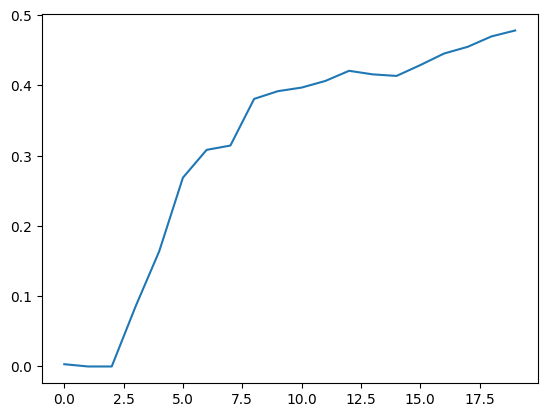

In [27]:
plt.plot(nmi)

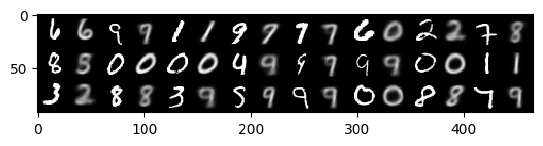

In [28]:
plot_reconstruction(model_G)

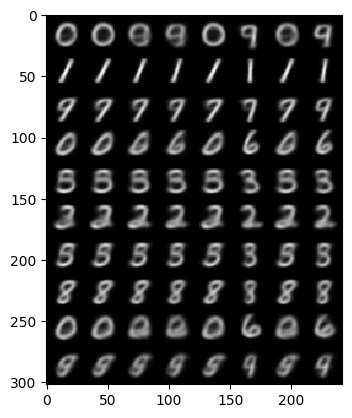

In [29]:
plot_conditional_generation(model_G, fix_number=None)

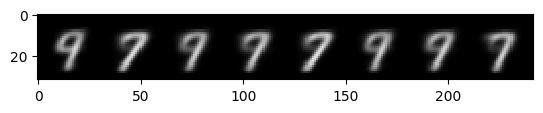

In [30]:
plot_conditional_generation(model_G, fix_number=2)